In [79]:
from __future__ import print_function

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

In [81]:
# importing dataframe

df = pd.read_csv('sports.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132327 entries, 0 to 132326
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  132327 non-null  int64  
 1   unitid                132327 non-null  int64  
 2   institution_name      132327 non-null  object 
 3   city_txt              132282 non-null  object 
 4   state_cd              132282 non-null  object 
 5   zip_text              132282 non-null  float64
 6   classification_code   132327 non-null  int64  
 7   classification_name   132327 non-null  object 
 8   classification_other  1685 non-null    object 
 9   ef_male_count         132327 non-null  int64  
 10  ef_female_count       132327 non-null  int64  
 11  ef_total_count        132327 non-null  int64  
 12  sector_cd             132327 non-null  int64  
 13  sector_name           132282 non-null  object 
 14  sportscode            132327 non-null  int64  
 15  

/tmp/ipykernel_566/2033913671.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sports.csv')


In [82]:
# dropping rows that have na values in men or women revenue
df = df.dropna(subset = ['rev_women', 'rev_men'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43614 entries, 1 to 132326
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  43614 non-null  int64  
 1   unitid                43614 non-null  int64  
 2   institution_name      43614 non-null  object 
 3   city_txt              43584 non-null  object 
 4   state_cd              43584 non-null  object 
 5   zip_text              43584 non-null  float64
 6   classification_code   43614 non-null  int64  
 7   classification_name   43614 non-null  object 
 8   classification_other  940 non-null    object 
 9   ef_male_count         43614 non-null  int64  
 10  ef_female_count       43614 non-null  int64  
 11  ef_total_count        43614 non-null  int64  
 12  sector_cd             43614 non-null  int64  
 13  sector_name           43584 non-null  object 
 14  sportscode            43614 non-null  int64  
 15  partic_men        

In [83]:
# dropping non-critical columns
df = df.drop(columns = ['unitid', 'zip_text','sector_name', 'classification_other', 'city_txt', 'institution_name', 'classification_code', 'classification_other', 'ef_total_count', 'sum_partic_men', 'sum_partic_women', 'total_rev_menwomen', 'total_exp_menwomen', 'sector_cd', 'partic_coed_men', 'sportscode', 'partic_coed_women'])

In [84]:
# making new columns that can distinguish which revenue 
df['gender'] = np.where(df['rev_men'] > df['rev_women'], 1, 0)

df.head()

,year,state_cd,classification_name,ef_male_count,ef_female_count,partic_men,partic_women,rev_men,rev_women,exp_men,exp_women,sports,gender
1,2015,AL,NCAA Division I-FCS,1923,2300,19.0,16.0,1211095.0,748833.0,817868.0,742460.0,Basketball,1
2,2015,AL,NCAA Division I-FCS,1923,2300,61.0,46.0,183333.0,315574.0,246949.0,251184.0,All Track Combined,0
7,2015,AL,NCAA Division I-FCS,1923,2300,7.0,10.0,78274.0,131145.0,99612.0,113886.0,Tennis,0
11,2015,AL,NCAA Division I-FBS,3397,4862,13.0,20.0,4189826.0,1966556.0,4189826.0,1962579.0,Basketball,1
13,2015,AL,NCAA Division I-FBS,3397,4862,10.0,7.0,407728.0,346987.0,407728.0,345979.0,Golf,1


In [85]:
# delete later

df = df.dropna()

In [125]:
# making dummbies for categorical values
year = pd.get_dummies(df['year'], drop_first = True)
state = pd.get_dummies(df['state_cd'], drop_first = True)
classification = pd.get_dummies(df['classification_name'], drop_first = True)
sports = pd.get_dummies(df['sports'], drop_first = True)

year

,2016,2017,2018,2019
1,0,0,0,0
2,0,0,0,0
7,0,0,0,0
11,0,0,0,0
13,0,0,0,0
...,...,...,...,...
132285,0,0,0,1
132292,0,0,0,1
132299,0,0,0,1
132302,0,0,0,1


In [87]:
# selecting only numeric columns annd dropping all rows that have na data

df_cleaned = df.drop(columns = ['year', 'state_cd', 'classification_name', 'sports'])

# df_cleaned = pd.concat([df_cleaned, year])




In [88]:
# reset index

df_cleaned.reset_index(drop=True, inplace=True)
year.reset_index(drop=True, inplace=True)
state.reset_index(drop=True, inplace=True)
classification.reset_index(drop=True, inplace=True)
sports.reset_index(drop=True, inplace=True)

year = year.astype(int)
state = state.astype(int)
classification = classification.astype(int)
sports = sports.astype(int)


In [89]:
# def convert(img, target_type_min, target_type_max, target_type):
#     imin = img.min()
#     imax = img.max()

#     a = (target_type_max - target_type_min) / (imax - imin)
#     b = target_type_max - a * imax
#     new_img = (a * img + b).astype(target_type)
#     return new_img

# year_float = convert(year, 0, 255, np.uint8)

# year_float = np.int16(year)



In [90]:
df_concat = pd.concat([df_cleaned, year, state, classification, sports], axis = 1)

print(df_concat.columns)

Index([             'ef_male_count',            'ef_female_count',
                       'partic_men',               'partic_women',
                          'rev_men',                  'rev_women',
                          'exp_men',                  'exp_women',
                           'gender',                         2016,
       ...
              'Swimming and Diving',               'Table Tennis',
                           'Tennis',    'Track and Field, Indoor',
         'Track and Field, Outdoor', 'Track and Field, X-Country',
                       'Volleyball',                 'Water Polo',
                   'Weight Lifting',                  'Wrestling'],
      dtype='object', length=113)


In [91]:
# df_cleaned = df_cleaned.dropna()


X = df_concat.drop(columns = ['gender'])
y = df_concat['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

train_df = X_train.copy()
test_df = X_test.copy()


In [92]:
y.value_counts()

1    25489
0    18095
Name: gender, dtype: int64

In [93]:


std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(train_df)

lm = LogisticRegression(max_iter = 100000)
lm.fit(X_train_scaled, y_train)

y_predict = lm.predict(X_train_scaled)

lm.score(X_train_scaled, y_train)



/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8901826942381048

In [94]:
X_test_scaled = std_scale.fit_transform(test_df)

lm = LogisticRegression(max_iter = 100000)
lm.fit(X_test_scaled, y_test)
    
y_predict = lm.predict(X_test_scaled)
lm.score(X_test_scaled, y_test)


/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8475392910404956

In [120]:
print('accuracy score is :' , accuracy_score(y_test, y_predict))

print('precision score is :', precision_score(y_test, y_predict))

print('recall score is :', recall_score(y_test, y_predict))

accuracy score is : 0.8475392910404956
precision score is : 0.8366071428571429
recall score is : 0.9188076093351638


In [95]:
# Cross validation scores

lm = LogisticRegression(max_iter = 1000)


scores = cross_val_score(lm, X_train_scaled, y_train, cv = 10, scoring = 'accuracy')


print(scores)
print("cross validation mean is :", scores.mean())

[0.88242042 0.8841411  0.88643533 0.89303126 0.88500143 0.88528821
 0.87639805 0.87865749 0.88869765 0.88095238]
cross validation mean is : 0.8841023317326006


In [96]:
# baseline porbability

baseline_prob = np.mean(y_train)
baseline_prob

0.5847936444202254

In [97]:
# Tuning logistic regression hyperparameter



# lm = LogisticRegression(max_iter = 100000)
# lm.fit(X_train_scaled, y_train)

# param_grid = [
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : [50, 10, 1.0, 0.1, 0.01],
#     'sovler' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
#     'max_iter' : [100, 1000, 2500, 5000, 10000, 100000]}
# ]

# clf = GridSearchCV(lm, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)

# best_clf = clf.fit(X_train_scaled, y_train)



In [98]:
# Confusion matrix for Logistic regression

#lm = LogisticRegression(max_iter = 1000)
# lm.fit(X_train_scaled, y_train)

# logistic_confusion = confusion_matrix(y_train, lm.predict(X_train_scaled))

# plt.figure(dpi=150)

# sns.heatmap(logistic_confusion, cmap=plt.cm.Blues, annot = True, square = True, 
#            xticklabels = df_concat['gender'],
#            yticklabels = df_concat['gender'])

In [121]:
# Randomforest

random = RandomForestClassifier()
random.fit(X_train, y_train)


/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier()

In [101]:

random_predict = random.predict(X_train)


r_val_scores = cross_val_score(random, X_train, y_train, cv=10, scoring = 'accuracy')

/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', '

In [124]:
r_scores = random.score(X_train, y_train)
r_scores

/home/wooyoung/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


1.0

In [102]:
# print('random forest score is :', r_scores)
print('random forest cross validation score is :', r_val_scores.mean())

random forest cross validation score is : 0.8900105975131629


In [111]:
graph_x = ['baseline', 'LR', 'RF']
graph_y = [baseline_prob, scores.mean(), r_val_scores.mean()]

In [112]:
ypos = np.arange(len(graph_x))

<BarContainer object of 3 artists>

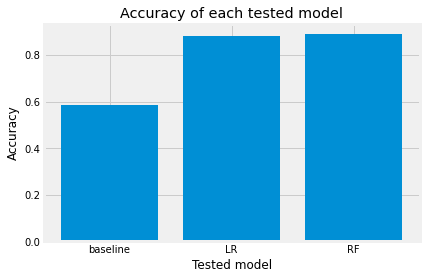

In [115]:
plt.xticks(ypos, graph_x)
plt.xlabel('Tested model')
plt.ylabel('Accuracy')
plt.title('Accuracy of each tested model')
plt.bar(ypos, graph_y)